# Fitting data from from non-linear relationship and interpretation of model

Here, we demonstrate how you can fit a nonlinear function with a deep neural network and interpret it with the gradient (local Taylor approximation) of the trained model.

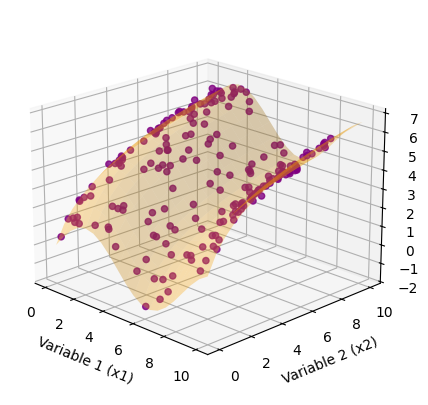

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Now let create a phenotype that depends the two independent variables in a non-linear way
def x1_transform(x):
    return np.sin(0.75 * x)
def x2_transform(x):
    return np.log1p(1.2 * x)
def non_linear_phenotype(x1, x2):
    return 1.5*x1_transform(x1) + 2 * x2_transform(x2)

def generate_nonlinear_phenotype(num_samples=200, noise_level=0.1, random_seed=42):
    np.random.seed(random_seed)
    # Generate two independent variables
    x1 = np.random.uniform(0, 10, num_samples)
    x2 = np.random.uniform(0, 10, num_samples)
    
    # Define the phenotype as a non-linear function of the two variables
    phenotype = non_linear_phenotype(x1, x2)
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, num_samples)
    phenotype += noise
    
    return x1, x2, phenotype

if __name__ == "__main__":
    x1, x2, phenotype = generate_nonlinear_phenotype()
    # Visualize the non-linear relationship in 3D
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x1, x2, phenotype, color='purple', alpha=0.8)
    ax.set_xlabel('Variable 1 (x1)')
    ax.set_ylabel('Variable 2 (x2)')
    ax.set_zlabel('Phenotype')
    # plot the true non-linear surface
    x1_grid, x2_grid = np.meshgrid(np.linspace(0, 10, 20), np.linspace(0, 10, 20))
    phenotype_grid = non_linear_phenotype(x1_grid, x2_grid)
    ax.plot_surface(x1_grid, x2_grid, phenotype_grid, color='orange', alpha=0.3)
    ax.view_init(elev=20, azim=-45)
    plt.show()


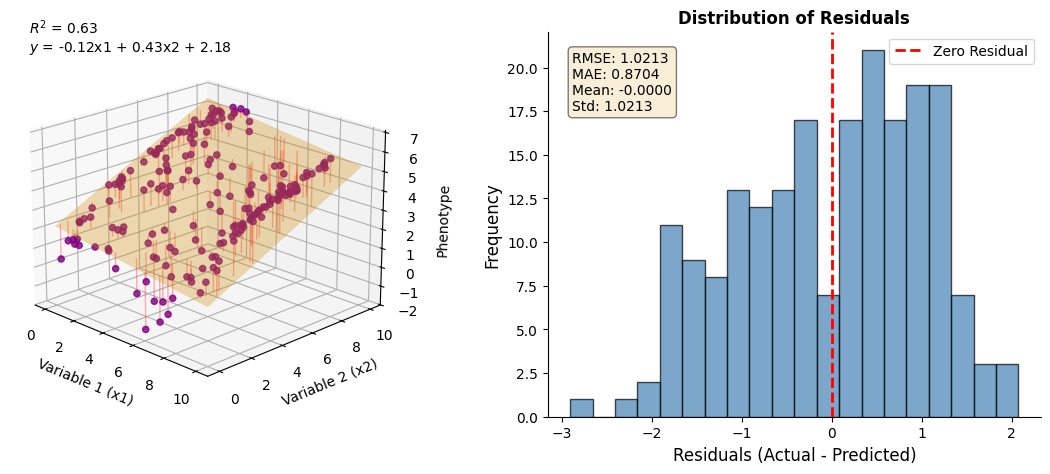

In [5]:
# Fit combined model with statsmodels to get summary statistics and uncertainty
import statsmodels.api as sm
X = np.column_stack((x1, x2))
model = sm.OLS(phenotype, sm.add_constant(X)).fit()

# plot meshgrid with the fitted plane into the 3D scatter
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x1, x2, phenotype, color='purple', alpha=0.8)
ax.set_xlabel('Variable 1 (x1)')
ax.set_ylabel('Variable 2 (x2)')
ax.set_zlabel('Phenotype')
# Create grid to plot the plane from the fit with both variables
x1_grid, x2_grid = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
X_grid = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
phenotype_grid = model.predict(sm.add_constant(X_grid)).reshape(x1_grid.shape)
ax.plot_surface(x1_grid, x2_grid, phenotype_grid, color='orange', alpha=0.3)
# Draw vertical lines from data points to the plane (residuals)
phenotype_pred = model.predict(sm.add_constant(X))
for i in range(len(x1)):
    ax.plot([x1[i], x1[i]], [x2[i], x2[i]], [phenotype[i], phenotype_pred[i]], 
             'r-', alpha=0.3, linewidth=1)


# Show R^2 and equation for combined fit
r2 = model.rsquared
ax.text2D(0.05, 0.95, f'$R^2$ = {r2:.2f}\n$y$ = {model.params[1]:.2f}x1 + {model.params[2]:.2f}x2 + {model.params[0]:.2f}', transform=ax.transAxes)
ax.view_init(elev=20, azim=-45)

# Right plot: Histogram of residuals
ax2 = fig.add_subplot(122)
residuals = phenotype - phenotype_pred
ax2.hist(residuals, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
ax2.set_xlabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend()

# Add statistics text
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(np.abs(residuals))
ax2.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nMean: {np.mean(residuals):.4f}\nStd: {np.std(residuals):.4f}', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

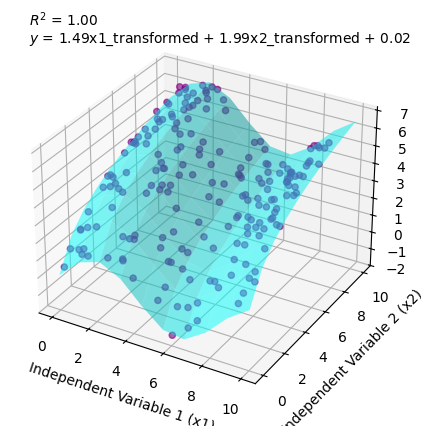

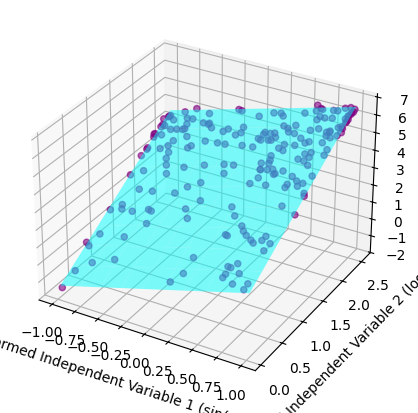

In [7]:
from sklearn import linear_model
# If we have the knowledge about the transformation, we use back-transformed features to do fit
x1_transformed = x1_transform(x1)
x2_transformed = x2_transform(x2)
X_transformed = np.column_stack((x1_transformed, x2_transformed))
model_transformed = linear_model.LinearRegression()
model_transformed.fit(X_transformed, phenotype)
# plot the fit in 3D
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, phenotype, color='purple', alpha=0.6)
ax.set_xlabel('Independent Variable 1 (x1)')
ax.set_ylabel('Independent Variable 2 (x2)')
ax.set_zlabel('Phenotype')
# Create grid to plot the plane from the transformed fit
x1_grid, x2_grid = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
x1_grid_transformed = x1_transform(x1_grid)
x2_grid_transformed = x2_transform(x2_grid)
phenotype_grid_transformed = model_transformed.predict(np.column_stack((x1_grid_transformed.ravel(), x2_grid_transformed.ravel()))).reshape(x1_grid.shape)
ax.plot_surface(x1_grid, x2_grid, phenotype_grid_transformed, color='cyan', alpha=0.5)
# Show R^2 and equation for transformed fit
r2_transformed = model_transformed.score(X_transformed, phenotype)
ax.text2D(0.05, 0.95, f'$R^2$ = {r2_transformed:.2f}\n$y$ = {model_transformed.coef_[0]:.2f}x1_transformed + {model_transformed.coef_[1]:.2f}x2_transformed + {model_transformed.intercept_:.2f}', transform=ax.transAxes)
plt.show()
# also plot the transformed variables against the phenotype in 3D
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_transformed, x2_transformed, phenotype, color='purple', alpha=0.6)
ax.set_xlabel('Transformed Independent Variable 1 (sin(0.75*x1))')
ax.set_ylabel('Transformed Independent Variable 2 (log1p(1.5*x2))')
ax.set_zlabel('Phenotype')
# Create grid to plot the plane from the transformed fit
x1_grid_transformed, x2_grid_transformed = np.meshgrid(np.linspace(np.min(x1_transformed), np.max(x1_transformed), 10), np.linspace(np.min(x2_transformed), np.max(x2_transformed), 10))
phenotype_grid_transformed = model_transformed.predict(np.column_stack((x1_grid_transformed.ravel(), x2_grid_transformed.ravel()))).reshape(x1_grid_transformed.shape)  
ax.plot_surface(x1_grid_transformed, x2_grid_transformed, phenotype_grid_transformed, color='cyan', alpha=0.5)
plt.show()

# Fit simple neural network with pytorch lightning to get idea of non-linear function

In [8]:
# Generally we do not know the non-linear function that the data follows, so we try to fit deep learning models to the data
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

class SimpleNN(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims, output_dim, learning_rate=1e-3):
        super(SimpleNN, self).__init__()
        self.learning_rate = learning_rate
        if hidden_dims is None:
            hidden_dims = [10]  # Default hidden dimension
        if isinstance(hidden_dims, int):
            hidden_dims = [hidden_dims]  # Convert to list
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
        self.criterion = nn.MSELoss()
        # Store losses for plotting
        self.train_losses = []
        self.val_losses = []
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self):
        # Collect training loss at the end of each epoch
        if 'train_loss' in self.trainer.callback_metrics:
            self.train_losses.append(self.trainer.callback_metrics.get('train_loss').item())
    
    def on_validation_epoch_end(self):
        # Collect validation loss at the end of each epoch
        if 'val_loss' in self.trainer.callback_metrics:
            self.val_losses.append(self.trainer.callback_metrics.get('val_loss').item())
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
if __name__ == "__main__":
    # Prepare data
    x1_tensor = torch.tensor(x1, dtype=torch.float32).unsqueeze(1)
    x2_tensor = torch.tensor(x2, dtype=torch.float32).unsqueeze(1)
    X_tensor = torch.cat((x1_tensor, x2_tensor), dim=1)
    phenotype_tensor = torch.tensor(phenotype, dtype=torch.float32).unsqueeze(1)
    dataset = torch.utils.data.TensorDataset(X_tensor, phenotype_tensor)
    
    # work with training, test, and validation set
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Initialize model
    hidden_layers = [30, 50, 100, 100, 50, 30]
    model = SimpleNN(input_dim=2, hidden_dims=hidden_layers, output_dim=1, learning_rate=1e-3)

    # Set up model checkpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',           # Monitor validation loss
        filename=f'./models/best-model-{"-".join(str(h) for h in hidden_layers)}',
        save_top_k=1,                 # Save only the best model
        mode='min',                   # 'min' because we want to minimize the loss
        verbose=True
    )
    
    # Set up early stopping callback
    early_stop_callback = EarlyStopping(
        monitor='val_loss',      # Monitor validation loss
        min_delta=0.00,          # Minimum change to qualify as an improvement
        patience=10,             # Number of epochs with no improvement after which training will be stopped
        verbose=True,            # Print messages
        mode='min'               # 'min' because we want to minimize the loss
    )
    
    # Check if GPU is available
    device = 'gpu' if torch.cuda.is_available() else 'cpu'
    print(f"Training on: {device.upper()}")
    if device == 'gpu':
        print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    
    # Train model with early stopping and checkpointing
    trainer = pl.Trainer(
        max_epochs=500, 
        logger=False, 
        callbacks=[early_stop_callback, checkpoint_callback],
        accelerator=device,           # Automatically use GPU if available
        devices=1                      # Use 1 device (GPU or CPU)
    )
    trainer.fit(model, train_dataloader, val_dataloader)
    
    # Load the best model checkpoint
    best_model_path = checkpoint_callback.best_model_path
    print(f"\nBest model saved at: {best_model_path}")
    print(f"Best validation loss: {checkpoint_callback.best_model_score:.6f}")
    
    train_losses_history = model.train_losses.copy()
    val_losses_history = model.val_losses.copy()
    # Load the best model weights
    model = SimpleNN.load_from_checkpoint(
        best_model_path,
        input_dim=2, 
        hidden_dims=hidden_layers, 
        output_dim=1, 
        learning_rate=1e-3
    )
    model.train_losses = train_losses_history
    model.val_losses = val_losses_history
    print(f"\nTraining completed on {device.upper()}")
    print("Best model loaded and ready for evaluation")
    model.eval()

/home/sasse/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/sasse/miniconda3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Training on: GPU
GPU Device: NVIDIA RTX 2000 Ada Generation Laptop GPU
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/sasse/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/sasse/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 76.03it/s, train_loss=21.10, val_loss=10.80]

Metric val_loss improved. New best score: 10.762
Epoch 0, global step 10: 'val_loss' reached 10.76153 (best 10.76153), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 207.45it/s, train_loss=15.10, val_loss=7.250]

Metric val_loss improved by 3.509 >= min_delta = 0.0. New best score: 7.253
Epoch 1, global step 20: 'val_loss' reached 7.25264 (best 7.25264), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 219.32it/s, train_loss=3.800, val_loss=5.350]

Metric val_loss improved by 1.902 >= min_delta = 0.0. New best score: 5.351
Epoch 2, global step 30: 'val_loss' reached 5.35082 (best 5.35082), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 292.16it/s, train_loss=2.530, val_loss=2.550]

Metric val_loss improved by 2.804 >= min_delta = 0.0. New best score: 2.547
Epoch 3, global step 40: 'val_loss' reached 2.54705 (best 2.54705), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 279.58it/s, train_loss=1.760, val_loss=1.800]

Metric val_loss improved by 0.749 >= min_delta = 0.0. New best score: 1.798
Epoch 4, global step 50: 'val_loss' reached 1.79838 (best 1.79838), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 293.66it/s, train_loss=1.040, val_loss=1.370]

Metric val_loss improved by 0.430 >= min_delta = 0.0. New best score: 1.368
Epoch 5, global step 60: 'val_loss' reached 1.36827 (best 1.36827), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 275.29it/s, train_loss=1.460, val_loss=1.140]

Metric val_loss improved by 0.232 >= min_delta = 0.0. New best score: 1.136
Epoch 6, global step 70: 'val_loss' reached 1.13641 (best 1.13641), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 280.22it/s, train_loss=1.030, val_loss=1.050]

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 1.050
Epoch 7, global step 80: 'val_loss' reached 1.04972 (best 1.04972), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 268.44it/s, train_loss=1.170, val_loss=0.975]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.975
Epoch 8, global step 90: 'val_loss' reached 0.97513 (best 0.97513), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 261.73it/s, train_loss=0.851, val_loss=0.952]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.952
Epoch 9, global step 100: 'val_loss' reached 0.95247 (best 0.95247), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 287.95it/s, train_loss=1.380, val_loss=0.915]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.915
Epoch 10, global step 110: 'val_loss' reached 0.91478 (best 0.91478), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 282.13it/s, train_loss=1.030, val_loss=0.896]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.896
Epoch 11, global step 120: 'val_loss' reached 0.89624 (best 0.89624), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 282.84it/s, train_loss=0.727, val_loss=0.895]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.895
Epoch 12, global step 130: 'val_loss' reached 0.89503 (best 0.89503), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 283.84it/s, train_loss=0.958, val_loss=0.809]

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 0.809
Epoch 13, global step 140: 'val_loss' reached 0.80872 (best 0.80872), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 285.87it/s, train_loss=0.753, val_loss=0.791]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.791
Epoch 14, global step 150: 'val_loss' reached 0.79105 (best 0.79105), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 15: 100%|██████████| 10/10 [00:00<00:00, 282.03it/s, train_loss=0.838, val_loss=0.754]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.754
Epoch 15, global step 160: 'val_loss' reached 0.75373 (best 0.75373), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 265.18it/s, train_loss=0.986, val_loss=0.757]

Epoch 16, global step 170: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 202.84it/s, train_loss=0.735, val_loss=0.676]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 0.676
Epoch 17, global step 180: 'val_loss' reached 0.67619 (best 0.67619), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 203.14it/s, train_loss=0.662, val_loss=0.707]

Epoch 18, global step 190: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 283.81it/s, train_loss=0.670, val_loss=0.626]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.626
Epoch 19, global step 200: 'val_loss' reached 0.62573 (best 0.62573), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 280.59it/s, train_loss=0.678, val_loss=0.628]

Epoch 20, global step 210: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 10/10 [00:00<00:00, 286.30it/s, train_loss=0.797, val_loss=0.566]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.566
Epoch 21, global step 220: 'val_loss' reached 0.56550 (best 0.56550), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 22: 100%|██████████| 10/10 [00:00<00:00, 271.71it/s, train_loss=0.660, val_loss=0.557]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.557
Epoch 22, global step 230: 'val_loss' reached 0.55659 (best 0.55659), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 285.07it/s, train_loss=0.650, val_loss=0.520]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.520
Epoch 23, global step 240: 'val_loss' reached 0.52002 (best 0.52002), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 268.53it/s, train_loss=0.767, val_loss=0.521]

Epoch 24, global step 250: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 286.53it/s, train_loss=0.558, val_loss=0.505]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.505
Epoch 25, global step 260: 'val_loss' reached 0.50481 (best 0.50481), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 26: 100%|██████████| 10/10 [00:00<00:00, 291.27it/s, train_loss=0.400, val_loss=0.479]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.479
Epoch 26, global step 270: 'val_loss' reached 0.47939 (best 0.47939), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 270.68it/s, train_loss=0.282, val_loss=0.471]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.471
Epoch 27, global step 280: 'val_loss' reached 0.47120 (best 0.47120), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 265.92it/s, train_loss=0.354, val_loss=0.454]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.454
Epoch 28, global step 290: 'val_loss' reached 0.45410 (best 0.45410), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 258.75it/s, train_loss=0.424, val_loss=0.495]

Epoch 29, global step 300: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 10/10 [00:00<00:00, 236.94it/s, train_loss=0.339, val_loss=0.463]

Epoch 30, global step 310: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 10/10 [00:00<00:00, 290.67it/s, train_loss=0.380, val_loss=0.509]

Epoch 31, global step 320: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 10/10 [00:00<00:00, 280.81it/s, train_loss=0.266, val_loss=0.522]

Epoch 32, global step 330: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 10/10 [00:00<00:00, 272.40it/s, train_loss=0.364, val_loss=0.463]

Epoch 33, global step 340: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 10/10 [00:00<00:00, 274.08it/s, train_loss=0.365, val_loss=0.450]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.450
Epoch 34, global step 350: 'val_loss' reached 0.45022 (best 0.45022), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 35: 100%|██████████| 10/10 [00:00<00:00, 273.49it/s, train_loss=0.204, val_loss=0.442]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.442
Epoch 35, global step 360: 'val_loss' reached 0.44207 (best 0.44207), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 36: 100%|██████████| 10/10 [00:00<00:00, 275.94it/s, train_loss=0.267, val_loss=0.458]

Epoch 36, global step 370: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 10/10 [00:00<00:00, 293.12it/s, train_loss=0.300, val_loss=0.428]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.428
Epoch 37, global step 380: 'val_loss' reached 0.42781 (best 0.42781), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 38: 100%|██████████| 10/10 [00:00<00:00, 267.27it/s, train_loss=0.225, val_loss=0.396]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.396
Epoch 38, global step 390: 'val_loss' reached 0.39563 (best 0.39563), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 39: 100%|██████████| 10/10 [00:00<00:00, 277.95it/s, train_loss=0.154, val_loss=0.373]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.373
Epoch 39, global step 400: 'val_loss' reached 0.37287 (best 0.37287), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 40: 100%|██████████| 10/10 [00:00<00:00, 285.57it/s, train_loss=0.165, val_loss=0.394]

Epoch 40, global step 410: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 10/10 [00:00<00:00, 277.01it/s, train_loss=0.168, val_loss=0.338]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.338
Epoch 41, global step 420: 'val_loss' reached 0.33812 (best 0.33812), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 42: 100%|██████████| 10/10 [00:00<00:00, 276.36it/s, train_loss=0.272, val_loss=0.301]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.301
Epoch 42, global step 430: 'val_loss' reached 0.30140 (best 0.30140), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 43: 100%|██████████| 10/10 [00:00<00:00, 272.11it/s, train_loss=0.144, val_loss=0.365]

Epoch 43, global step 440: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 10/10 [00:00<00:00, 269.78it/s, train_loss=0.214, val_loss=0.269]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.269
Epoch 44, global step 450: 'val_loss' reached 0.26862 (best 0.26862), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 45: 100%|██████████| 10/10 [00:00<00:00, 286.96it/s, train_loss=0.157, val_loss=0.257]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.257
Epoch 45, global step 460: 'val_loss' reached 0.25662 (best 0.25662), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 46: 100%|██████████| 10/10 [00:00<00:00, 265.24it/s, train_loss=0.208, val_loss=0.218]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.218
Epoch 46, global step 470: 'val_loss' reached 0.21818 (best 0.21818), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 47: 100%|██████████| 10/10 [00:00<00:00, 275.10it/s, train_loss=0.0741, val_loss=0.213]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.213
Epoch 47, global step 480: 'val_loss' reached 0.21317 (best 0.21317), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 48: 100%|██████████| 10/10 [00:00<00:00, 185.01it/s, train_loss=0.168, val_loss=0.280] 

Epoch 48, global step 490: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 229.57it/s, train_loss=0.216, val_loss=0.176]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.176
Epoch 49, global step 500: 'val_loss' reached 0.17642 (best 0.17642), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 50: 100%|██████████| 10/10 [00:00<00:00, 250.81it/s, train_loss=0.104, val_loss=0.154]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.154
Epoch 50, global step 510: 'val_loss' reached 0.15422 (best 0.15422), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 51: 100%|██████████| 10/10 [00:00<00:00, 264.42it/s, train_loss=0.0815, val_loss=0.169]

Epoch 51, global step 520: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 10/10 [00:00<00:00, 278.38it/s, train_loss=0.0963, val_loss=0.130]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.130
Epoch 52, global step 530: 'val_loss' reached 0.13044 (best 0.13044), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 53: 100%|██████████| 10/10 [00:00<00:00, 272.46it/s, train_loss=0.0687, val_loss=0.112]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.112
Epoch 53, global step 540: 'val_loss' reached 0.11237 (best 0.11237), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 54: 100%|██████████| 10/10 [00:00<00:00, 222.43it/s, train_loss=0.156, val_loss=0.123] 

Epoch 54, global step 550: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 10/10 [00:00<00:00, 291.68it/s, train_loss=0.0787, val_loss=0.124]

Epoch 55, global step 560: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 10/10 [00:00<00:00, 288.84it/s, train_loss=0.0308, val_loss=0.140]

Epoch 56, global step 570: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 10/10 [00:00<00:00, 272.49it/s, train_loss=0.0496, val_loss=0.097]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.097
Epoch 57, global step 580: 'val_loss' reached 0.09705 (best 0.09705), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 58: 100%|██████████| 10/10 [00:00<00:00, 267.87it/s, train_loss=0.056, val_loss=0.0706]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.071
Epoch 58, global step 590: 'val_loss' reached 0.07055 (best 0.07055), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 59: 100%|██████████| 10/10 [00:00<00:00, 288.62it/s, train_loss=0.0583, val_loss=0.0661]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.066
Epoch 59, global step 600: 'val_loss' reached 0.06614 (best 0.06614), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 60: 100%|██████████| 10/10 [00:00<00:00, 278.36it/s, train_loss=0.0698, val_loss=0.0671]

Epoch 60, global step 610: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 10/10 [00:00<00:00, 268.36it/s, train_loss=0.0548, val_loss=0.0536]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.054
Epoch 61, global step 620: 'val_loss' reached 0.05359 (best 0.05359), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 62: 100%|██████████| 10/10 [00:00<00:00, 251.04it/s, train_loss=0.0369, val_loss=0.0539]

Epoch 62, global step 630: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 10/10 [00:00<00:00, 263.95it/s, train_loss=0.0292, val_loss=0.0519]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.052
Epoch 63, global step 640: 'val_loss' reached 0.05191 (best 0.05191), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 64: 100%|██████████| 10/10 [00:00<00:00, 268.62it/s, train_loss=0.0609, val_loss=0.0773]

Epoch 64, global step 650: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 10/10 [00:00<00:00, 248.96it/s, train_loss=0.0308, val_loss=0.0575]

Epoch 65, global step 660: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 10/10 [00:00<00:00, 266.96it/s, train_loss=0.0423, val_loss=0.0394]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.039
Epoch 66, global step 670: 'val_loss' reached 0.03942 (best 0.03942), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 67: 100%|██████████| 10/10 [00:00<00:00, 276.81it/s, train_loss=0.0186, val_loss=0.0357]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.036
Epoch 67, global step 680: 'val_loss' reached 0.03566 (best 0.03566), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 68: 100%|██████████| 10/10 [00:00<00:00, 257.69it/s, train_loss=0.023, val_loss=0.0538] 

Epoch 68, global step 690: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 10/10 [00:00<00:00, 288.74it/s, train_loss=0.0364, val_loss=0.0325]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.032
Epoch 69, global step 700: 'val_loss' reached 0.03246 (best 0.03246), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 70: 100%|██████████| 10/10 [00:00<00:00, 267.85it/s, train_loss=0.0291, val_loss=0.0649]

Epoch 70, global step 710: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 10/10 [00:00<00:00, 267.67it/s, train_loss=0.0185, val_loss=0.0323]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.032
Epoch 71, global step 720: 'val_loss' reached 0.03226 (best 0.03226), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 72: 100%|██████████| 10/10 [00:00<00:00, 253.19it/s, train_loss=0.0162, val_loss=0.0337]

Epoch 72, global step 730: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 10/10 [00:00<00:00, 254.93it/s, train_loss=0.0136, val_loss=0.0355]

Epoch 73, global step 740: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 10/10 [00:00<00:00, 275.44it/s, train_loss=0.020, val_loss=0.0336] 

Epoch 74, global step 750: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 10/10 [00:00<00:00, 275.29it/s, train_loss=0.0284, val_loss=0.0266]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.027
Epoch 75, global step 760: 'val_loss' reached 0.02658 (best 0.02658), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 76: 100%|██████████| 10/10 [00:00<00:00, 291.71it/s, train_loss=0.032, val_loss=0.0307] 

Epoch 76, global step 770: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 10/10 [00:00<00:00, 290.73it/s, train_loss=0.0151, val_loss=0.0264] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026
Epoch 77, global step 780: 'val_loss' reached 0.02642 (best 0.02642), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 78: 100%|██████████| 10/10 [00:00<00:00, 234.55it/s, train_loss=0.017, val_loss=0.0248] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.025
Epoch 78, global step 790: 'val_loss' reached 0.02477 (best 0.02477), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 79: 100%|██████████| 10/10 [00:00<00:00, 260.12it/s, train_loss=0.0175, val_loss=0.0421]

Epoch 79, global step 800: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 10/10 [00:00<00:00, 261.92it/s, train_loss=0.0182, val_loss=0.030] 

Epoch 80, global step 810: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 10/10 [00:00<00:00, 241.59it/s, train_loss=0.0247, val_loss=0.025]

Epoch 81, global step 820: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 10/10 [00:00<00:00, 181.10it/s, train_loss=0.015, val_loss=0.0254]

Epoch 82, global step 830: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 10/10 [00:00<00:00, 227.03it/s, train_loss=0.0172, val_loss=0.0234]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023
Epoch 83, global step 840: 'val_loss' reached 0.02345 (best 0.02345), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 84: 100%|██████████| 10/10 [00:00<00:00, 290.28it/s, train_loss=0.0719, val_loss=0.0417]

Epoch 84, global step 850: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 10/10 [00:00<00:00, 294.79it/s, train_loss=0.0391, val_loss=0.062] 

Epoch 85, global step 860: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 10/10 [00:00<00:00, 275.80it/s, train_loss=0.0102, val_loss=0.0228]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023
Epoch 86, global step 870: 'val_loss' reached 0.02277 (best 0.02277), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 87: 100%|██████████| 10/10 [00:00<00:00, 291.02it/s, train_loss=0.0129, val_loss=0.0218]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022
Epoch 87, global step 880: 'val_loss' reached 0.02178 (best 0.02178), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 88: 100%|██████████| 10/10 [00:00<00:00, 291.05it/s, train_loss=0.0232, val_loss=0.0603]

Epoch 88, global step 890: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 10/10 [00:00<00:00, 276.36it/s, train_loss=0.0169, val_loss=0.0393]

Epoch 89, global step 900: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 10/10 [00:00<00:00, 275.50it/s, train_loss=0.0119, val_loss=0.0411]

Epoch 90, global step 910: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 10/10 [00:00<00:00, 262.21it/s, train_loss=0.0149, val_loss=0.0341]

Epoch 91, global step 920: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 10/10 [00:00<00:00, 268.12it/s, train_loss=0.0356, val_loss=0.0371]

Epoch 92, global step 930: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 10/10 [00:00<00:00, 268.09it/s, train_loss=0.0263, val_loss=0.0456]

Epoch 93, global step 940: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 10/10 [00:00<00:00, 262.39it/s, train_loss=0.0111, val_loss=0.0289]

Epoch 94, global step 950: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 10/10 [00:00<00:00, 294.79it/s, train_loss=0.0171, val_loss=0.0242] 

Epoch 95, global step 960: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 10/10 [00:00<00:00, 297.20it/s, train_loss=0.0166, val_loss=0.0216]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022
Epoch 96, global step 970: 'val_loss' reached 0.02159 (best 0.02159), saving model to '/home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt' as top 1


Epoch 97: 100%|██████████| 10/10 [00:00<00:00, 275.04it/s, train_loss=0.024, val_loss=0.0282] 

Epoch 97, global step 980: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 10/10 [00:00<00:00, 282.63it/s, train_loss=0.0195, val_loss=0.0299]

Epoch 98, global step 990: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 286.69it/s, train_loss=0.0233, val_loss=0.041] 

Epoch 99, global step 1000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 10/10 [00:00<00:00, 308.10it/s, train_loss=0.0149, val_loss=0.0305]

Epoch 100, global step 1010: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 10/10 [00:00<00:00, 302.59it/s, train_loss=0.0214, val_loss=0.0407]

Epoch 101, global step 1020: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 10/10 [00:00<00:00, 302.10it/s, train_loss=0.016, val_loss=0.038]  

Epoch 102, global step 1030: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 10/10 [00:00<00:00, 285.96it/s, train_loss=0.0111, val_loss=0.029]

Epoch 103, global step 1040: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 10/10 [00:00<00:00, 287.08it/s, train_loss=0.0231, val_loss=0.0292]

Epoch 104, global step 1050: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 10/10 [00:00<00:00, 290.18it/s, train_loss=0.00789, val_loss=0.029] 

Epoch 105, global step 1060: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 10/10 [00:00<00:00, 321.47it/s, train_loss=0.0143, val_loss=0.0326]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.022. Signaling Trainer to stop.
Epoch 106, global step 1070: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 10/10 [00:00<00:00, 307.74it/s, train_loss=0.0143, val_loss=0.0326]

Best model saved at: /home/sasse/Git/Preparation_GS2F_seminar/notebooks/checkpoints/./models/best-model-30-50-100-100-50-30-v3.ckpt
Best validation loss: 0.021585

Training completed on GPU
Best model loaded and ready for evaluation


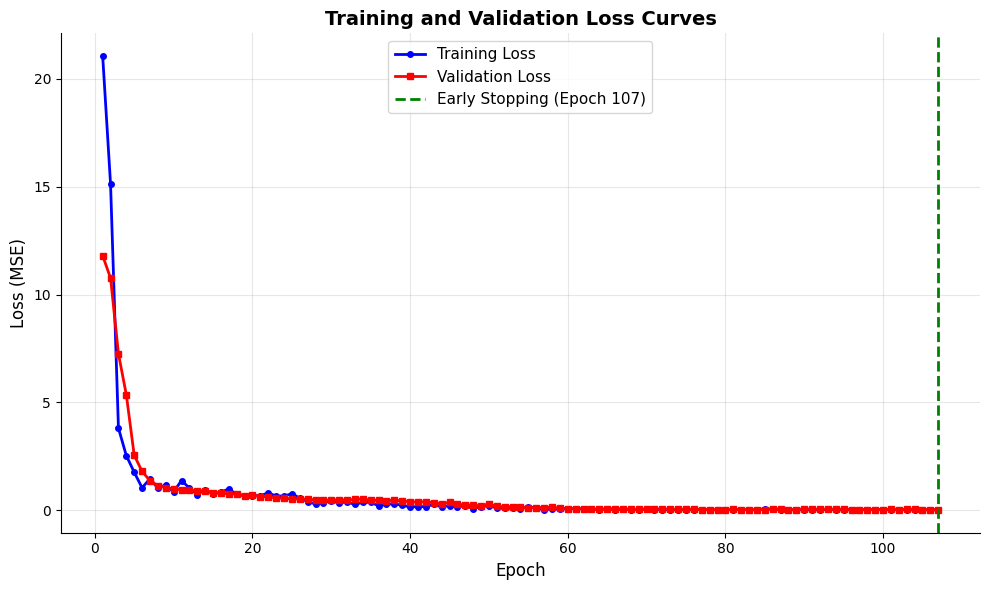

Final Training Loss: 0.014283
Final Validation Loss: 0.029019
Training stopped at epoch: 107
Total train loss entries: 107
Total val loss entries: 108


In [9]:
# Plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure both lists have the same length by taking the minimum
min_len = min(len(model.train_losses), len(model.val_losses))
epochs = range(1, min_len + 1)

ax.plot(epochs, model.train_losses[:min_len], 'b-o', label='Training Loss', linewidth=2, markersize=4)
ax.plot(epochs, model.val_losses[:min_len], 'r-s', label='Validation Loss', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Mark the early stopping point if training stopped early
if min_len < 500:
    ax.axvline(x=min_len, color='green', linestyle='--', linewidth=2, 
               label=f'Early Stopping (Epoch {min_len})')
    ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Print final losses
print(f"Final Training Loss: {model.train_losses[min_len-1]:.6f}")
print(f"Final Validation Loss: {model.val_losses[min_len-1]:.6f}")
print(f"Training stopped at epoch: {min_len}")
print(f"Total train loss entries: {len(model.train_losses)}")
print(f"Total val loss entries: {len(model.val_losses)}")

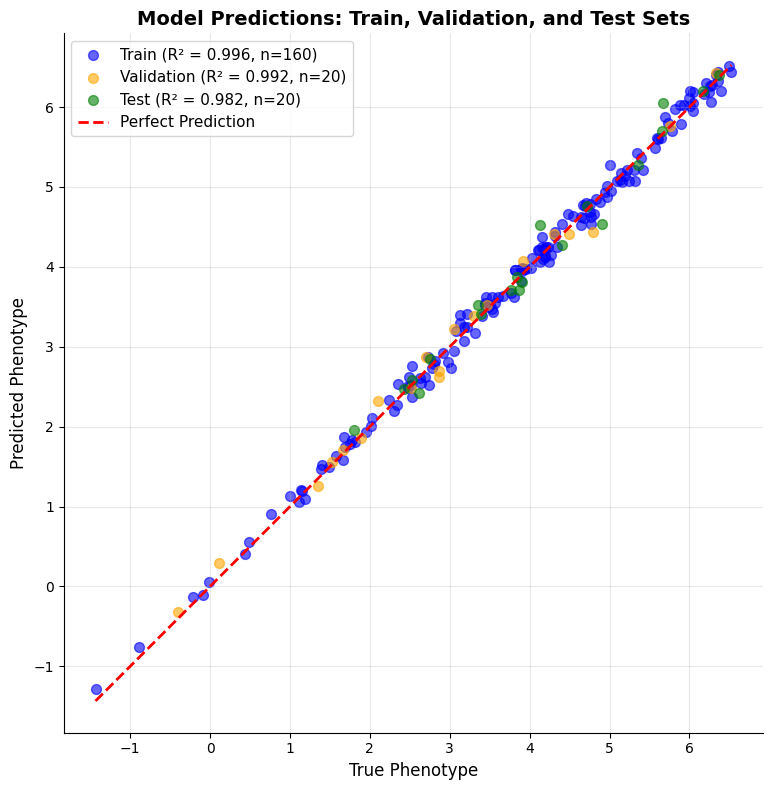


Detailed Statistics:
Set          R²         MSE          Samples   
--------------------------------------------
Train        0.9959     0.011619     160       
Validation   0.9923     0.021585     20        
Test         0.9816     0.030358     20        


In [10]:
# Plot predictions for train, validation, and test sets with different colors
from sklearn.metrics import r2_score

model.eval()
model.to('cpu')  # Ensure model is on CPU for evaluation
with torch.no_grad():
    # Get predictions for train dataset using batches
    train_pred_list = []
    train_true_list = []
    for batch in train_dataloader:
        x, y = batch
        pred = model(x).cpu().numpy().flatten()
        true = y.cpu().numpy().flatten()
        train_pred_list.append(pred)
        train_true_list.append(true)
    train_pred = np.concatenate(train_pred_list)
    train_true = np.concatenate(train_true_list)
    
    # Get predictions for validation dataset using batches
    val_pred_list = []
    val_true_list = []
    for batch in val_dataloader:
        x, y = batch
        pred = model(x).cpu().numpy().flatten()
        true = y.cpu().numpy().flatten()
        val_pred_list.append(pred)
        val_true_list.append(true)
    val_pred = np.concatenate(val_pred_list)
    val_true = np.concatenate(val_true_list)
    
    # Get predictions for test dataset using batches
    test_pred_list = []
    test_true_list = []
    for batch in test_dataloader:
        x, y = batch
        pred = model(x).cpu().numpy().flatten()
        true = y.cpu().numpy().flatten()
        test_pred_list.append(pred)
        test_true_list.append(true)
    test_pred = np.concatenate(test_pred_list)
    test_true = np.concatenate(test_true_list)

# Calculate R² for each set
r2_train = r2_score(train_true, train_pred)
r2_val = r2_score(val_true, val_pred)
r2_test = r2_score(test_true, test_pred)

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train_true, train_pred, color='blue', alpha=0.6, s=50, label=f'Train (R² = {r2_train:.3f}, n={len(train_true)})')
ax.scatter(val_true, val_pred, color='orange', alpha=0.6, s=50, label=f'Validation (R² = {r2_val:.3f}, n={len(val_true)})')
ax.scatter(test_true, test_pred, color='green', alpha=0.6, s=50, label=f'Test (R² = {r2_test:.3f}, n={len(test_true)})')

# Plot identity line
all_values = np.concatenate([train_true, val_true, test_true, train_pred, val_pred, test_pred])
min_val, max_val = all_values.min(), all_values.max()
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('True Phenotype', fontsize=12)
ax.set_ylabel('Predicted Phenotype', fontsize=12)
ax.set_title('Model Predictions: Train, Validation, and Test Sets', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"{'Set':<12} {'R²':<10} {'MSE':<12} {'Samples':<10}")
print("-" * 44)
print(f"{'Train':<12} {r2_train:<10.4f} {np.mean((train_true - train_pred)**2):<12.6f} {len(train_true):<10}")
print(f"{'Validation':<12} {r2_val:<10.4f} {np.mean((val_true - val_pred)**2):<12.6f} {len(val_true):<10}")
print(f"{'Test':<12} {r2_test:<10.4f} {np.mean((test_true - test_pred)**2):<12.6f} {len(test_true):<10}")

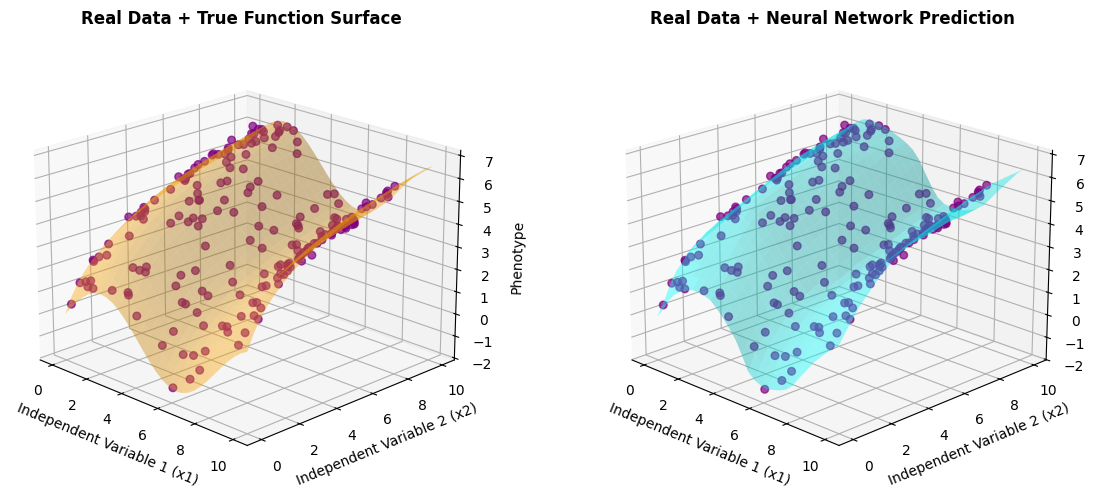


Comparison of True Function vs Neural Network Prediction:
Mean Absolute Error on grid: 0.0973
RMSE on grid: 0.1344
Max Absolute Error on grid: 0.6308


In [11]:
# Plot 3D comparison: Real phenotypes, true function surface, and model predictions
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))

# First subplot: Real data points + True function surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x1, x2, phenotype, color='purple', alpha=0.7, s=30, label='Real Data')
ax1.set_xlabel('Independent Variable 1 (x1)', fontsize=10)
ax1.set_ylabel('Independent Variable 2 (x2)', fontsize=10)
ax1.set_zlabel('Phenotype', fontsize=10)

# Create meshgrid for the true function
x1_grid, x2_grid = np.meshgrid(np.linspace(0, 10, 30), np.linspace(0, 10, 30))
# True non-linear function: phenotype = sin(0.75*x1) + 2*log1p(1.5*x2)
phenotype_true_grid = non_linear_phenotype(x1_grid, x2_grid)
ax1.plot_surface(x1_grid, x2_grid, phenotype_true_grid, color='orange', alpha=0.4, label='True Function')
ax1.set_title('Real Data + True Function Surface', fontsize=12, fontweight='bold')
ax1.view_init(elev=20, azim=-45)

# Second subplot: Real data points + Neural network predictions
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x1, x2, phenotype, color='purple', alpha=0.7, s=30, label='Real Data')
ax2.set_xlabel('Independent Variable 1 (x1)', fontsize=10)
ax2.set_ylabel('Independent Variable 2 (x2)', fontsize=10)
ax2.set_zlabel('Phenotype', fontsize=10)

# Create predictions from the neural network on the meshgrid
model.eval()
with torch.no_grad():
    x1_grid_flat = x1_grid.ravel()
    x2_grid_flat = x2_grid.ravel()
    X_grid = np.column_stack((x1_grid_flat, x2_grid_flat))
    X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)
    phenotype_pred_grid = model(X_grid_tensor).cpu().numpy().reshape(x1_grid.shape)

ax2.plot_surface(x1_grid, x2_grid, phenotype_pred_grid, color='cyan', alpha=0.4, label='NN Prediction')
ax2.set_title('Real Data + Neural Network Prediction', fontsize=12, fontweight='bold')
ax2.view_init(elev=20, azim=-45)

plt.show()

# Print comparison metrics
print("\nComparison of True Function vs Neural Network Prediction:")
print(f"Mean Absolute Error on grid: {np.mean(np.abs(phenotype_true_grid - phenotype_pred_grid)):.4f}")
print(f"RMSE on grid: {np.sqrt(np.mean((phenotype_true_grid - phenotype_pred_grid)**2)):.4f}")
print(f"Max Absolute Error on grid: {np.max(np.abs(phenotype_true_grid - phenotype_pred_grid)):.4f}")

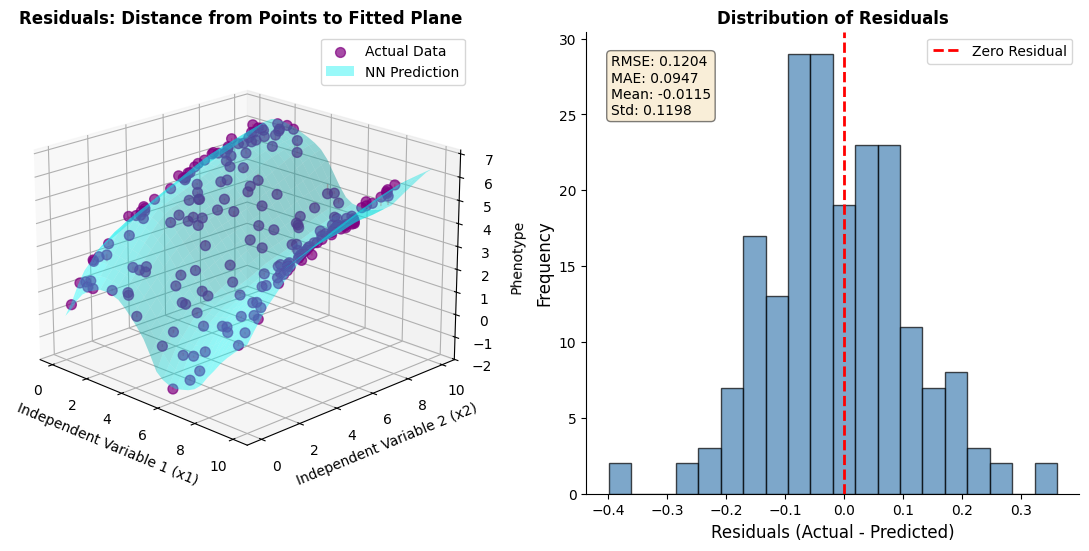

In [12]:
# Visualize residuals: show vertical lines from data points to the fitted plane
fig = plt.figure(figsize=(14, 6))

# Left plot: 3D scatter with residual lines
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x1, x2, phenotype, color='purple', alpha=0.7, s=50, label='Actual Data')

# Create predictions from the neural network on the meshgrid
model.eval()
with torch.no_grad():
    x1_grid_flat = x1_grid.ravel()
    x2_grid_flat = x2_grid.ravel()
    X_grid = np.column_stack((x1_grid_flat, x2_grid_flat))
    X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)
    phenotype_pred_grid = model(X_grid_tensor).cpu().numpy().reshape(x1_grid.shape)

ax1.plot_surface(x1_grid, x2_grid, phenotype_pred_grid, color='cyan', alpha=0.4, label='NN Prediction')
ax1.set_title('Real Data + Neural Network Prediction', fontsize=12, fontweight='bold')
ax1.view_init(elev=20, azim=-45)

# Calculate predicted values for each data point
with torch.no_grad():
    X_data = torch.tensor(np.column_stack((x1, x2)), dtype=torch.float32)
    phenotype_pred = model(X_data).cpu().numpy().flatten()

# Draw vertical lines from data points to the plane (residuals)
for i in range(len(x1)):
    ax1.plot([x1[i], x1[i]], [x2[i], x2[i]], [phenotype[i], phenotype_pred[i]], 
             'r-', alpha=0.3, linewidth=1)

ax1.set_xlabel('Independent Variable 1 (x1)')
ax1.set_ylabel('Independent Variable 2 (x2)')
ax1.set_zlabel('Phenotype')
ax1.set_title('Residuals: Distance from Points to Fitted Plane', fontsize=12, fontweight='bold')
ax1.view_init(elev=20, azim=-45)
ax1.legend()

# Right plot: Histogram of residuals
ax2 = fig.add_subplot(122)
residuals = phenotype - phenotype_pred
ax2.hist(residuals, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
ax2.set_xlabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend()

# Add statistics text
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(np.abs(residuals))
ax2.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nMean: {np.mean(residuals):.4f}\nStd: {np.std(residuals):.4f}', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

## Approximate non-linear NN function with locally linear approximation to interpret model
To understand the behaviour of the model, i.e. the relationship between the independent variables and the dependent variable, the phenotype better, we can approximate the model with locally linear functions, that tell us about its behaviour at this particular position.

Gradient at position (2,7): dPhenotype/dx1 = 0.1014, dPhenotype/dx2 = 0.3022
Gradient at position (7,4): dPhenotype/dx1 = 0.6841, dPhenotype/dx2 = 0.2868


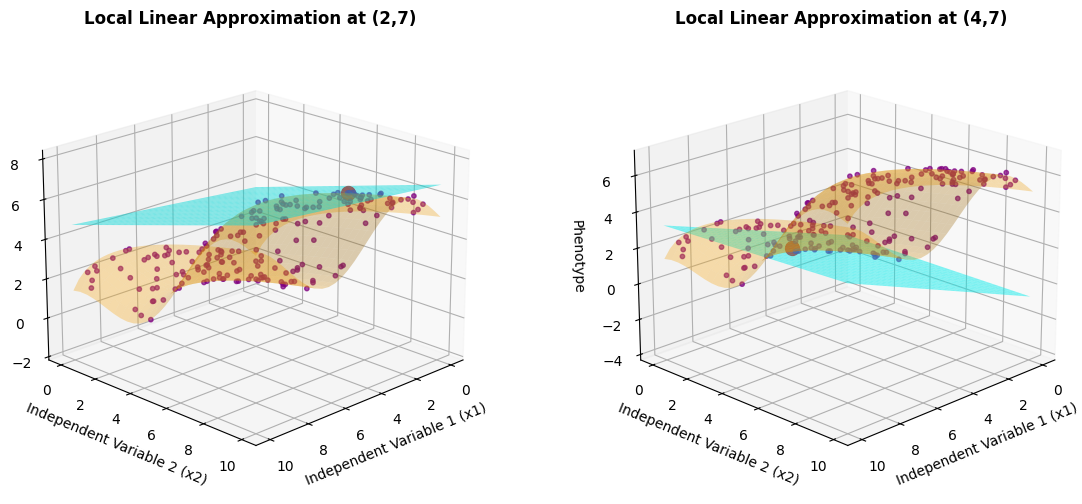

In [13]:
# Lets see if we can use the model to get a linear approximation of the data at a specific position
# To do that we create the gradient at a specific position

# Compute gradient at 2 positions 
position1 = torch.tensor([[2.,7.]], requires_grad=True)
position2 = torch.tensor([[7.0, 4.0]], requires_grad=True)
model.eval()
model.zero_grad()
output1 = model(position1)
output1.backward()
grad1 = position1.grad.detach().numpy().flatten()
model.zero_grad()
output2 = model(position2)
output2.backward()
grad2 = position2.grad.detach().numpy().flatten()
print(f"Gradient at position (2,7): dPhenotype/dx1 = {grad1[0]:.4f}, dPhenotype/dx2 = {grad1[1]:.4f}")
print(f"Gradient at position (7,4): dPhenotype/dx1 = {grad2[0]:.4f}, dPhenotype/dx2 = {grad2[1]:.4f}")

# Using the gradients, we can create local linear approximations at these positions
def local_linear_approximation(x1, x2, position, gradient, intercept):
    return intercept + gradient[0] * (x1 - position[0,0].item()) + gradient[1] * (x2 - position[0,1].item())

# Calculate intercepts
intercept1 = model(position1).item()
intercept2 = model(position2).item()
# Create grid for plotting
x1_grid, x2_grid = np.meshgrid(np.linspace(0, 10, 30), np.linspace(0, 10, 30))
# Local linear approximations
phenotype_local1 = local_linear_approximation(x1_grid, x2_grid, position1, grad1, intercept1)
phenotype_local2 = local_linear_approximation(x1_grid, x2_grid, position2, grad2, intercept2)
# Plot the local linear approximations in 3D with the real data and the true function
fig = plt.figure(figsize=(14, 6)) 
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x1, x2, phenotype, color='purple', alpha=0.7, s=10, label='Real Data')
ax1.set_xlabel('Independent Variable 1 (x1)', fontsize=10)
ax1.set_ylabel('Independent Variable 2 (x2)', fontsize=10)
ax1.set_zlabel('Phenotype', fontsize=10)
# True non-linear function surface
phenotype_true_grid = non_linear_phenotype(x1_grid, x2_grid)
ax1.plot_surface(x1_grid, x2_grid, phenotype_true_grid, color='orange', alpha=0.3, label='True Function')
# Local linear approximation at position1
ax1.plot_surface(x1_grid, x2_grid, phenotype_local1, color='cyan', alpha=0.5, label='Local Linear Approximation (6,6)')
ax1.set_title('Local Linear Approximation at (2,7)', fontsize=12, fontweight='bold')
ax1.view_init(elev=20, azim=45) 
# show the point of approximation
ax1.scatter(position1[0,0].item(), position1[0,1].item(), intercept1, color='red', s=100, label='Point of Approximation', zorder=5)
# plot the second local linear approximation
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x1, x2, phenotype, color='purple', alpha=0.7, s=10, label='Real Data')
ax2.set_xlabel('Independent Variable 1 (x1)', fontsize=10)
ax2.set_ylabel('Independent Variable 2 (x2)', fontsize=10)
ax2.set_zlabel('Phenotype', fontsize=10)
# True non-linear function surface
ax2.plot_surface(x1_grid, x2_grid, phenotype_true_grid, color='orange', alpha=0.3, label='True Function')
# Local linear approximation at position2
ax2.plot_surface(x1_grid, x2_grid, phenotype_local2, color='cyan', alpha=0.5, label='Local Linear Approximation (2,3)')
ax2.set_title('Local Linear Approximation at (4,7)', fontsize=12, fontweight='bold')
ax2.view_init(elev=20, azim=45) 
# show the point of approximation
ax2.scatter(position2[0,0].item(), position2[0,1].item(), intercept2, color='red', s=100, label='Point of Approximation', zorder=100)
model.eval()
plt.show()
